# Modelo 2

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [44]:
df=pd.read_csv("reservaciones_clean.csv")
df.drop(columns="Cliente_Disp",inplace=True)
df.head()

,h_num_per,h_num_adu,h_num_men,h_num_noc,h_tot_hab,ID_Paquete,ID_Segmento_Comp,ID_Agencia,ID_empresa,ID_Tipo_Habitacion,ID_canal,h_fec_lld_ok,h_fec_sda_ok,Reservacion,ID_estatus_reservaciones,h_can_res,h_cod_reserva,h_edo,h_codigop,h_tfa_total
0,2,2,0,3,1,1,14,112,1,25,10,2019-11-07,2019-11-10,1,9,9,31047,85,333,2659.98
1,4,4,0,4,1,2,14,112,1,25,10,2019-12-01,2019-12-05,1,9,9,31047,54,398,1764.00
2,2,2,0,4,1,1,14,112,1,23,10,2019-12-01,2019-12-05,1,9,9,31047,75,6566,2660.04
3,4,3,0,3,1,2,14,112,1,24,10,2019-12-08,2019-12-11,1,9,9,31047,54,2961,1995.03
4,2,2,0,4,1,1,5,14,1,4,13,2019-12-08,2019-12-12,1,9,12,23266,85,1224,13369.92


In [45]:
df['h_fec_lld_ok']=pd.to_datetime(df['h_fec_lld_ok'])
df['h_fec_sda_ok']=pd.to_datetime(df['h_fec_sda_ok'])
df['h_fec_sda_ok']=df['h_fec_sda_ok'].astype('int64')/1e9
df=df.sort_values('h_fec_lld_ok')

In [46]:
df2=df.copy()
df2=df2[['h_fec_lld_ok','h_tfa_total']]
df2=df2.groupby('h_fec_lld_ok').sum().reset_index()

Text(0.5, 0, 'h_fec_lld_ok')

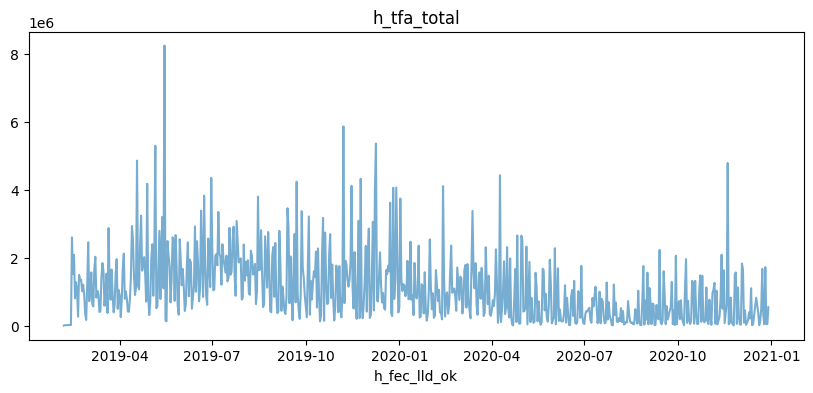

In [47]:
plt.figure(figsize=(10, 4))
plt.plot(df2['h_fec_lld_ok'], df2['h_tfa_total'], linestyle='-', alpha=0.6)
plt.title('h_tfa_total')
plt.xlabel('h_fec_lld_ok')

## Suavizado

In [48]:
from scipy.signal import savgol_filter
df2['smoothed'] = df2['h_tfa_total'].rolling(window=7).mean() #media movil simple
df2['smoothed2'] = df2['h_tfa_total'].ewm(span=7, adjust=False).mean() # Suavizado exponencial
df2['smoothed3'] = savgol_filter(df2['h_tfa_total'], window_length=15, polyorder=2)

Text(0.5, 0, 'Fecha')

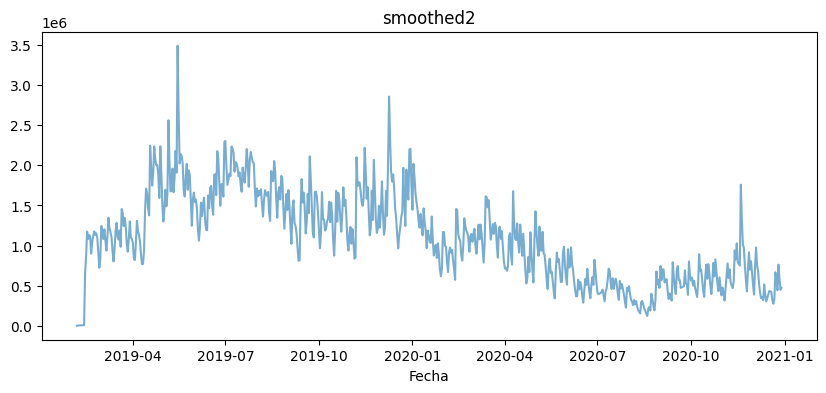

In [49]:
plt.figure(figsize=(10, 4))
plt.plot(df2['h_fec_lld_ok'], df2['smoothed2'], linestyle='-', alpha=0.6)
plt.title('smoothed2')
plt.xlabel('Fecha')

## GRU

In [52]:
## Importar librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, GRU
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
df_gru=df2[["h_fec_lld_ok","smoothed2"]]

In [54]:
shapiro_test = stats.shapiro(df_gru['smoothed2'])
shapiro_test

# Selección de escalador basada en normalidad
if shapiro_test.pvalue < 0.05:
    print("Distribución NO normal → Usando MinMaxScaler")
    scaler = MinMaxScaler()
else:
    print("Distribución normal → Usando StandardScaler")
    scaler = StandardScaler()

# Escalado de datos
scaled_data = scaler.fit_transform(df_gru[['smoothed2']])

Distribución NO normal → Usando MinMaxScaler


In [55]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [56]:
window = 30
X , y = create_sequences(scaled_data, window)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Ajustar forma para GRU para que sea [muestras, pasos de tiempo, características]
X = np.reshape(X, (X.shape[ 0 ], X.shape[ 1 ], 1 ))

In [ ]:
def build_gru_model(units=64, dropout_rate=0.2, learning_rate=0.001, n_layers=1):
    model = Sequential()
    
    
    model.add(GRU(units, return_sequences=(n_layers > 1), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))

    
    for i in range(n_layers - 1):
        model.add(GRU(units, return_sequences=(i < n_layers - 2)))  # Solo la última capa sin return_sequences
        model.add(Dropout(dropout_rate))
    
    # Capa de salida
    model.add(Dense(1))

    # Compilación
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mape'])
    
    return model


In [ ]:


model = KerasRegressor(model=build_gru_model, verbose=0)

param_grid = {
    'model__units': [32, 64],
    'model__dropout_rate': [0.2, 0.3],
    'model__learning_rate': [0.001, 0.0005],
    'model__n_layers': [1, 2],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train, y_train)

c:\Users\gersa\OneDrive\Escritorio\tca_proyecto\lstm\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\gersa\OneDrive\Escritorio\tca_proyecto\lstm\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\gersa\OneDrive\Escritorio\tca_proyecto\lstm\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\gersa\OneDrive\Escrito

In [60]:
print("Mejores hiperparámetros:")
for param, value in grid_result.best_params_.items():
    print(f"{param}: {value}")


Mejores hiperparámetros:
batch_size: 16
epochs: 100
model__dropout_rate: 0.2
model__learning_rate: 0.0005
model__n_layers: 2
model__units: 64


In [61]:
print(f"\nMejor score MAPE: {grid_result.best_score_:.4f}")


Mejor score MAPE: 0.6324


###  Revisar con X_test y y_test

In [62]:

params = {
    
    'dropout_rate': 0.2,
    'learning_rate': 0.0005,
    'n_layers': 2,
    'units': 64
}

epochs=100
final_model=build_gru_model(**params)

In [ ]:
history = final_model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_test, y_test),
        verbose=1
    )

# Evaluar el modelo en el test set
loss = final_model.evaluate(X_test, y_test)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0539 - mape: 55.0795 - val_loss: 0.0164 - val_mape: 99.4317
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0121 - mape: 33.2416 - val_loss: 0.0044 - val_mape: 47.6255
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0089 - mape: 25.7613 - val_loss: 0.0060 - val_mape: 56.9185
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0086 - mape: 25.8090 - val_loss: 0.0039 - val_mape: 42.4450
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0078 - mape: 22.5795 - val_loss: 0.0034 - val_mape: 36.9697
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0082 - mape: 22.7826 - val_loss: 0.0029 - val_mape: 29.4391
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0086 - mape: 22.1436 - val_loss: 0.0031 - val_mape: 31.7352
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0072 - mape: 19.8632 - val_loss: 0.0034 - val_mape: 35.0100
Epoch 9/100
17/17 ━━━━━━

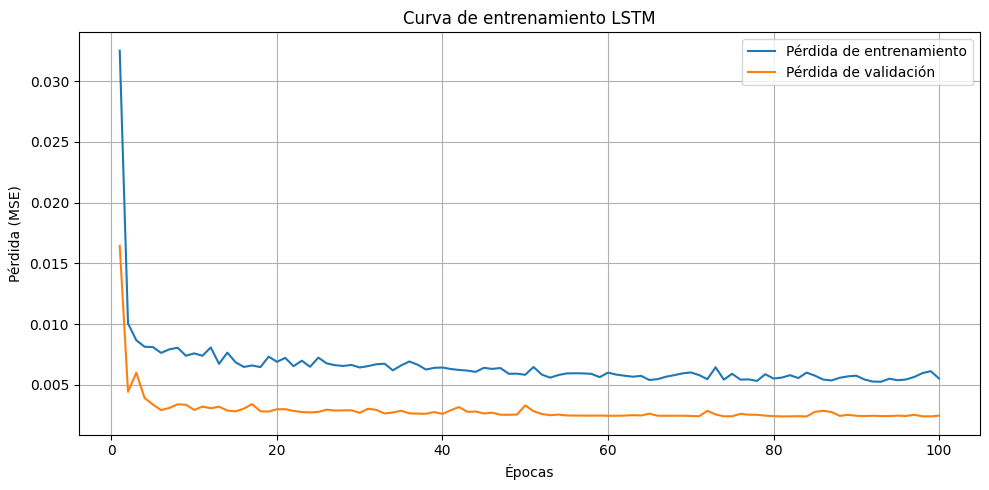

In [64]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(loss) + 1)

# Crear la gráfica
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, loss, label='Pérdida de entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Curva de entrenamiento LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Hacer predicciones
predictions = final_model.predict(X_test) 
# Transformar de forma inversa las predicciones
predictions = scaler.inverse_transform(predictions) 
y_actual = scaler.inverse_transform(y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


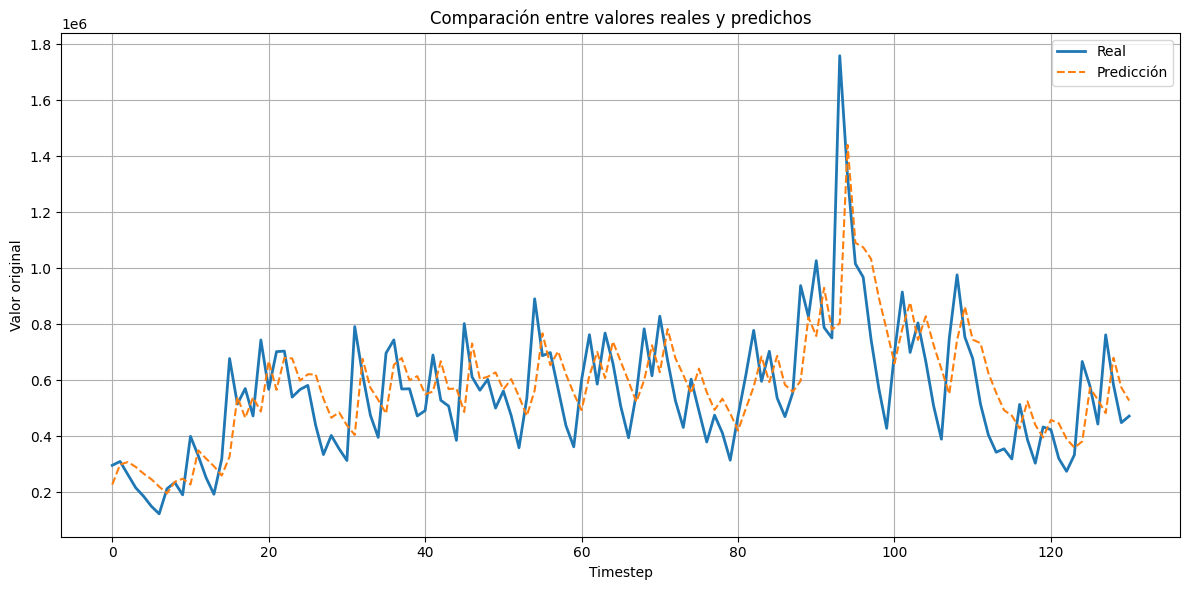

In [66]:
plt.figure(figsize=(12, 6))
plt.plot(y_actual, label='Real', linewidth=2)
plt.plot(predictions, label='Predicción', linestyle='--')
plt.title('Comparación entre valores reales y predichos')
plt.xlabel('Timestep')
plt.ylabel('Valor original')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Predicciones reales

In [ ]:
n_future_steps = 15
predictions = []

current_input = X[-1:]  # (1, timesteps, features)

for _ in range(n_future_steps):
    pred_scaled = final_model.predict(current_input)[0]
    predictions.append(pred_scaled)

    # Convertir la predicción a (1, 1, 1) para concatenar
    pred_scaled_reshaped = np.array(pred_scaled).reshape(1, 1, 1)

    # Reemplazar la ventana: quitar el primer paso y agregar el nuevo
    current_input = np.concatenate([current_input[:, 1:, :], pred_scaled_reshaped], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [71]:
predictions_inv = scaler.inverse_transform(predictions)

In [ ]:
last_date = last_date = df_gru["h_fec_lld_ok"].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future_steps, freq='D')


In [82]:
df_future = pd.DataFrame({
    'fecha': future_dates,
    'prediccion': predictions_inv.flatten()
})
df_future.set_index('fecha', inplace=True)
print(df_future)

               prediccion
fecha                    
2020-12-30  527313.037536
2020-12-31  567932.720424
2021-01-01  585454.555156
2021-01-02  599440.982676
2021-01-03  611696.998599
2021-01-04  623628.724881
2021-01-05  635611.942221
2021-01-06  647697.049442
2021-01-07  659831.775318
2021-01-08  671959.219630
2021-01-09  684041.986348
2021-01-10  696059.062959
2021-01-11  708000.671364
2021-01-12  719862.598657
2021-01-13  731642.556348


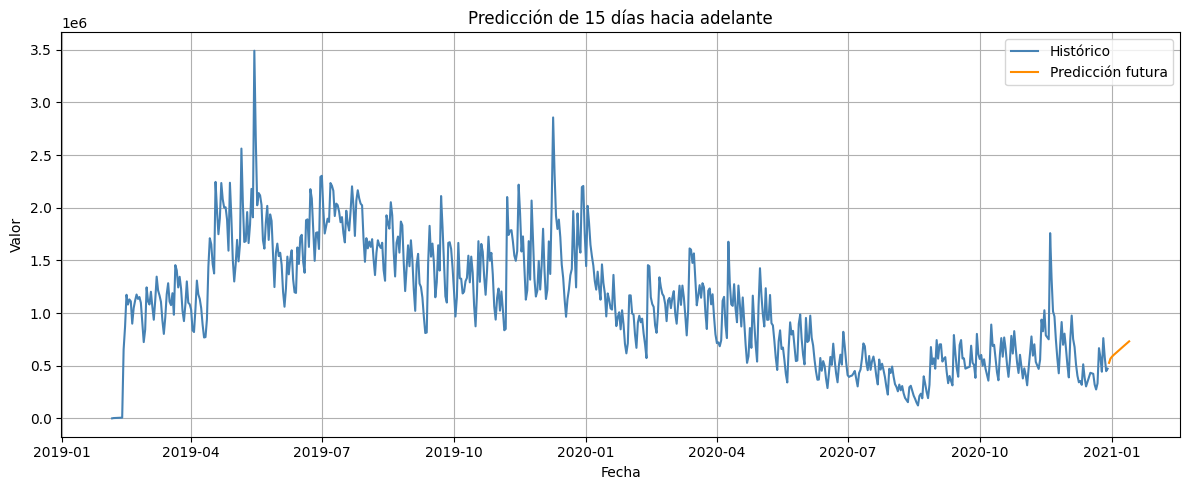

In [ ]:
plt.figure(figsize=(12, 5))
#Serie histórica
plt.plot(df_gru["h_fec_lld_ok"], df_gru['smoothed2'], label='Histórico', color='steelblue')

#Predicción
plt.plot(df_future.index, df_future['prediccion'].values, label='Predicción futura', color='darkorange')

plt.title("Predicción de 15 días hacia adelante")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
